In [1]:
#!pip install scikit-optimize
#!pip install anomatools

In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.datasets import make_moons
from anomatools.models import SSDO
from skopt import gp_minimize
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.io import arff
import warnings

from BALLAD import *

def ignore_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=Warning)
    warnings.simplefilter(action='ignore', category=DeprecationWarning)
ignore_warnings()


numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject


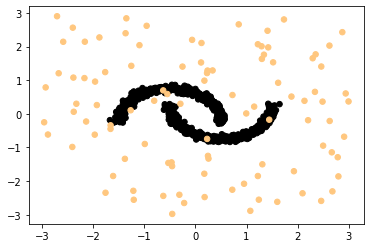

In [3]:
np.random.seed(331)
n_samples = 900
n_anom = 100
X = make_moons(n_samples=n_samples, noise=0.05, random_state=0)[0]-np.array([0.5, 0.25])
X = np.concatenate([X, np.random.uniform(low=-3, high=3, size=(n_anom, 2))], axis=0)

y_true = np.zeros(n_samples + n_anom, np.int)
y_true[-n_anom:] = 1
colors = np.array(["#377eb8", "#ff7f00"])
plt.scatter(X[:, 0], X[:, 1], s=30, c=y_true, cmap=plt.cm.copper)

plt.show()

In [4]:
c_r = 0.05
c_fp = 1
c_fn = 1
metric = 'entropy'
save = ''
seed = 331
np.random.seed(seed)
dataset_name = ''
data_path = ''
tot_budget = 200
pool_budget = 10

# Load data
X_train, y_train, X_val, y_val, X_test, y_test, contamination = load_dataset(dataset_name, data_path, 
                                                                             random_state=seed)

y_train_semitargets = np.zeros(len(y_train), np.int)
y_val_semitargets = np.zeros(len(y_val), np.int)

oldpred_AL, oldpred_LR = initialize_loop(np.concatenate((X_train, X_val)),contamination,seed,c_r,c_fp,
                                         c_fn,metric)

indicesRanked = np.array([])
used_budget = 0
ALreward = .99
LRreward = 1
strg = ''

while used_budget < tot_budget:
    pool_budget = min(pool_budget, tot_budget-used_budget)
    detector = SSDO()
    #Add labels
    if ALreward >= LRreward:
        print("Budget used:", used_budget+pool_budget,"out of:", tot_budget,
              "--> Current Chosen Strategy: ___ Active Learning ___")
        strg = 'AL'

        y_train_semitargets = add_training_labels(y_train_semitargets, y_train, indicesRanked, pool_budget)
        detector.fit(X_train, y_train_semitargets)
        labeld_idx_val = np.where(y_val_semitargets !=0)[0]
        if len(labeld_idx_val) > 0:
            val_probs = detector.predict_proba(X_val[labeld_idx_val])[:,1]
            rejection_threshold = set_rejection_threshold(val_probs, y_val[labeld_idx_val], c_r, c_fp, c_fn)
        else:
            rejection_threshold = 0.0

        predictions = detector.predict(np.concatenate((X_train, X_val)))
        probs = detector.predict_proba(np.concatenate((X_train, X_val)))[:,1]

        ALreward, _, oldpred_AL, _ = measure_rewards(predictions, probs, rejection_threshold, 
                                                                     oldpred_AL, oldpred_LR, metric = metric)

        al_scores = abs(detector.predict_proba(X_train)[:,1] - 0.5)
        indicesRanked = np.argsort(al_scores)
    
    else:
        print("Budget used:", used_budget+pool_budget,"out of:", tot_budget,
              "--> Current Chosen Strategy: ___ Learning to Reject ___")
        strg = 'LR'

        y_val_semitargets = add_validation_labels(y_val_semitargets, y_val, pool_budget)
        detector.fit(X_train, y_train_semitargets)
        labeled_idx_val = np.where(y_val_semitargets !=0)[0]
        val_probs = detector.predict_proba(X_val[labeled_idx_val])[:,1]
        rejection_threshold = set_rejection_threshold(val_probs, y_val[labeled_idx_val], c_r, c_fp, c_fn)
        predictions = detector.predict(np.concatenate((X_train, X_val)))
        probs = detector.predict_proba(np.concatenate((X_train, X_val)))[:,1]
        _, LRreward, _, oldpred_LR = measure_rewards(predictions, probs, rejection_threshold, 
                                                     oldpred_AL, oldpred_LR, metric = metric)

    test_pred = detector.predict(X_test)
    test_prob = detector.predict_proba(X_test)[:,1]
    test_cost_NoRej, _, _, _ = cost_function(y_test, test_pred, c_r, c_fp, c_fn)
    print("Test cost with NO rejection:", np.round(test_cost_NoRej,5))
    reject_indx = reject(test_pred, test_prob, rejection_threshold)
    test_pred[reject_indx] = 2
    test_cost_Rej, fpr, fnr, rr = cost_function(y_test, test_pred, c_r, c_fp, c_fn)
    print("Test cost with rejection:", np.round(test_cost_Rej,5))
    used_budget+=pool_budget

Budget used: 10 out of: 200 --> Current Chosen Strategy: ___ Learning to Reject ___
Test cost with NO rejection: 0.02
Test cost with rejection: 0.00675
Budget used: 20 out of: 200 --> Current Chosen Strategy: ___ Active Learning ___
Test cost with NO rejection: 0.04
Test cost with rejection: 0.0135
Budget used: 30 out of: 200 --> Current Chosen Strategy: ___ Learning to Reject ___
Test cost with NO rejection: 0.04
Test cost with rejection: 0.013
Budget used: 40 out of: 200 --> Current Chosen Strategy: ___ Learning to Reject ___
Test cost with NO rejection: 0.04
Test cost with rejection: 0.013
Budget used: 50 out of: 200 --> Current Chosen Strategy: ___ Active Learning ___
Test cost with NO rejection: 0.03
Test cost with rejection: 0.01325
Budget used: 60 out of: 200 --> Current Chosen Strategy: ___ Active Learning ___
Test cost with NO rejection: 0.025
Test cost with rejection: 0.01675
Budget used: 70 out of: 200 --> Current Chosen Strategy: ___ Active Learning ___
Test cost with NO re